In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import gwdet
from pdet import VT_pop_uniform_q, p

/Users/Federico/Documents/Corsi di studio/Università/Tesi/master_thesis/.venv/lib/python3.11/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal
/Users/Federico/Documents/Corsi di studio/Università/Tesi/master_thesis/.venv/lib/python3.11/site-packages/pykerr/qnm.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for r

In [2]:
# m1_min, m1_max, m1_len = 1, 100, 100
# q = 0.8 # m2 / m1, with m2 <= m1. Below q = 0.3 plots become a bit messy
# z_min, z_max, z_len = 1e-4, 2.2, 50
# m1 = np.linspace(m1_min, m1_max, m1_len)
# m2 = m1 * q
# z = np.linspace(z_min, z_max, z_len)

m1_min, m1_max, m1_len = 1, 100, 100
q = 0.8
z_min, z_max, z_len = 1e-4, 10, 100
m1 = np.linspace(m1_min, m1_max, m1_len)
m2 = m1 * q
z = np.linspace(z_min, z_max, z_len)

In [3]:
# p = gwdet.detectability()

In [4]:
# with open('data/18213_ET10kmcolumns.txt', 'r') as file:
#     new_lines = []
#     while True:
#         line = file.readline()
#         if line == '':
#             break
#         else:
#             line = line.split(' ')
#             new_lines.append(line[0] + ' ' + line[3])

# with open('data/ET_ASD_file.txt', 'x') as file:
#     file.writelines(new_lines)

In [5]:
with open('data/ET_ASD_file.txt', 'r') as file:
    lines = file.readlines()

f = np.zeros(len(lines))
for i, line in enumerate(lines):
    f[i] = float(line.split(' ')[0])

delta_f = f[1:] - f[:-1]

In [6]:
np.min(delta_f)

np.float64(0.0030758579429499555)

In [7]:
# p = gwdet.detectability(directory='data/', psd_from_path=True, psd_path='data/ET_ASD_file.txt', is_asd_file=True,
#                         flow=1., deltaf=1 / 40, snrthreshold=8., massmin=1, massmax=200, zmin=1e-4, zmax=2.2)

In [8]:
p_det = np.zeros((z_len, m1_len))

for i, _z in enumerate(z):
    p_det[i] = p(m1, m2, np.zeros(m1_len) + _z)

In [9]:
np.sum(p_det < 0)

np.int64(3)

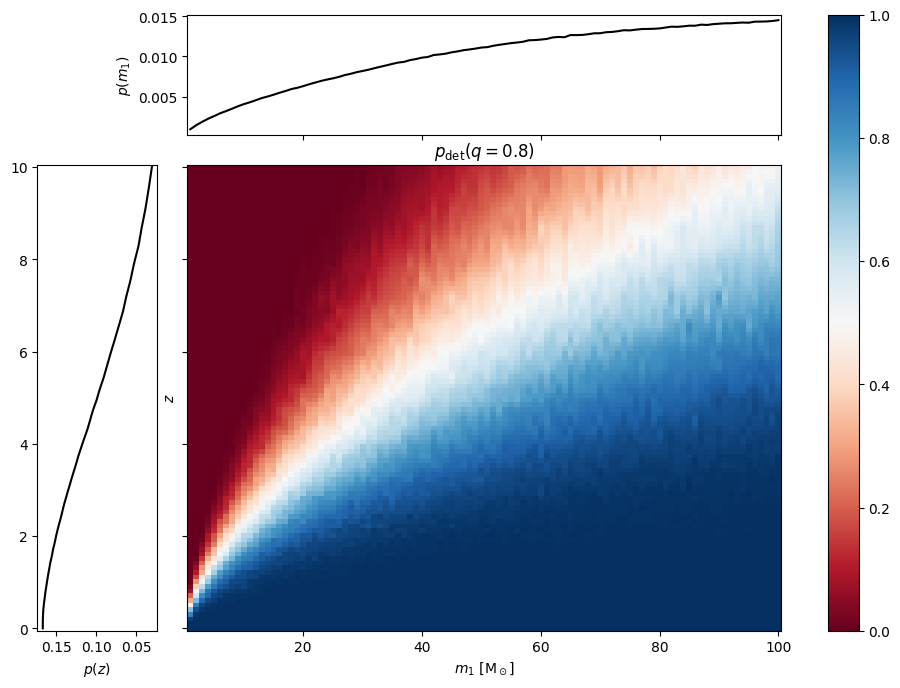

In [10]:
fig, ax = plt.subplots(figsize=(12, 8))
divider = make_axes_locatable(ax)

ax_m = divider.append_axes('top', 1.2, pad=0.3, sharex=ax)
ax_z = divider.append_axes('left', 1.2, pad=0.3, sharey=ax)

ax.tick_params(labelleft=False)
ax_m.tick_params(labelbottom=False)

ax.set_title(r'$p_\text{{det}} (q = {0})$'.format(q))
ax.set_xlabel(r'$m_1\ [\text{M}_\odot$]')
ax.set_ylabel(r'$z$')

cmap = plt.colormaps['RdBu']
im = ax.pcolormesh(m1, z, p_det, cmap=cmap, norm=mpl.colors.Normalize(vmin=0, vmax=1))

fig.colorbar(im, ax=ax)

ax_m.set_ylabel(r'$p(m_1)$')

ax_m.plot(m1, np.sum(p_det, axis=0) / np.trapezoid(np.sum(p_det, axis=0), m1), color='black')

ax_z.set_xlabel(r'$p(z)$')

ax_z.xaxis.set_inverted(True)

ax_z.plot(np.sum(p_det, axis=1) / np.trapezoid(np.sum(p_det, axis=1), z), z, color='black')

plt.show()

In [11]:
if __name__ == '__main__':
    VT = VT_pop_uniform_q(1, z, m1, q)

Computing VT for each (m, z) pair for a uniformly distributed population of sources with fixed q = 0.8:   0%|          | 0/9801 [00:00<?, ?it/s]/Users/Federico/Documents/Corsi di studio/Università/Tesi/master_thesis/.venv/lib/python3.11/site-packages/pykerr/qnm.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/Federico/Documents/Corsi di studio/Università/Tesi/master_thesis/.venv/lib/python3.11/site-packages/pykerr/qnm.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/Federico/Documents/Corsi di studio/Università/Tesi/master_thesis/.ve

In [12]:
np.sum(VT < 0)

np.int64(0)

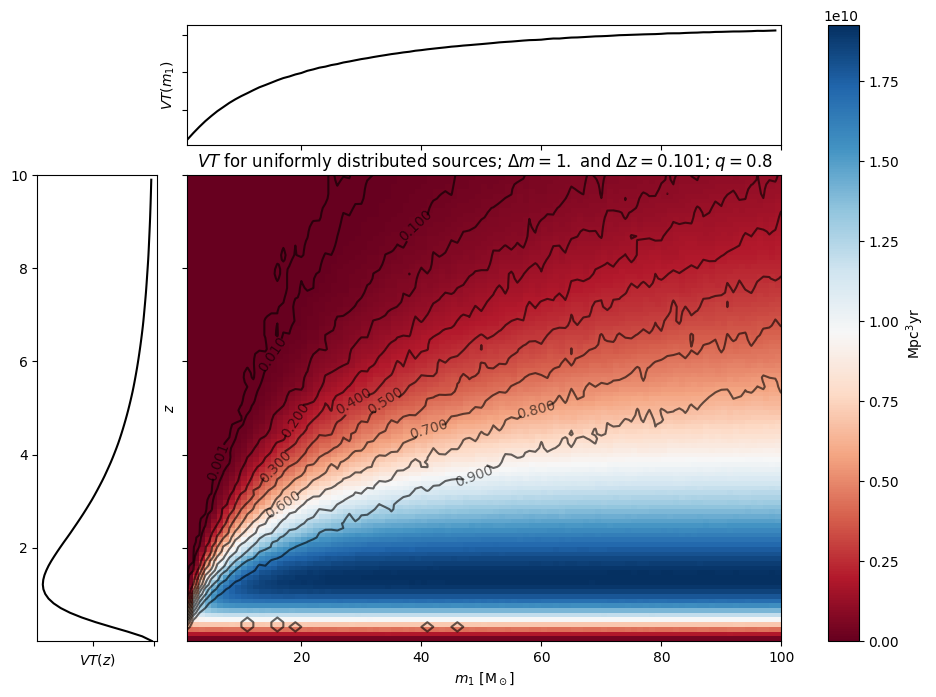

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))

divider = make_axes_locatable(ax)

ax_m = divider.append_axes('top', 1.2, pad=0.3, sharex=ax)
ax_z = divider.append_axes('left', 1.2, pad=0.3, sharey=ax)

ax.tick_params(labelleft=False)
ax_m.tick_params(labelbottom=False, labelleft=False)
ax_z.tick_params(labelbottom=False)

ax.set_title(r'$VT$ for uniformly distributed sources; $\Delta m = {0}$ and $\Delta z = {1}$; $q = {2}$'.format(np.format_float_positional((m1_max - m1_min) / (m1_len - 1), 3),
                                                                                                                np.format_float_positional((z_max - z_min) / (z_len - 1), 3),
                                                                                                                np.format_float_positional(q, 3)))
ax.set_xlabel(r'$m_1\ [\text{M}_\odot$]')
ax.set_ylabel(r'$z$')

# VT heatmap
cmap = plt.colormaps['RdBu']
im = ax.pcolormesh(m1, z, VT, cmap=cmap, norm=mpl.colors.Normalize(vmin=np.min(VT), vmax=np.max(VT)))

# pdet contour levels
levels = [1e-3, 1e-2, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
cf = ax.contour(m1, z, p_det, levels=levels, colors='black', alpha=0.6)
ax.clabel(cf)

cbar = fig.colorbar(im, ax=ax, label=r'$\text{Mpc}^3 \text{yr}$')

ax_m.set_ylabel(r'$VT(m_1)$')

ax_m.plot(m1[:-1], np.sum(VT, axis=0), color='black')

ax_z.set_xlabel(r'$VT(z)$')

ax_z.xaxis.set_inverted(True)

ax_z.plot(np.sum(VT, axis=1), z[:-1], color='black')

plt.show()

/var/folders/05/2fbv44555hx420qclxnfbd4c0000gn/T/ipykernel_28336/3420535131.py:8: RuntimeWarning: divide by zero encountered in divide
  VT_ratio_map = target_VT / VT


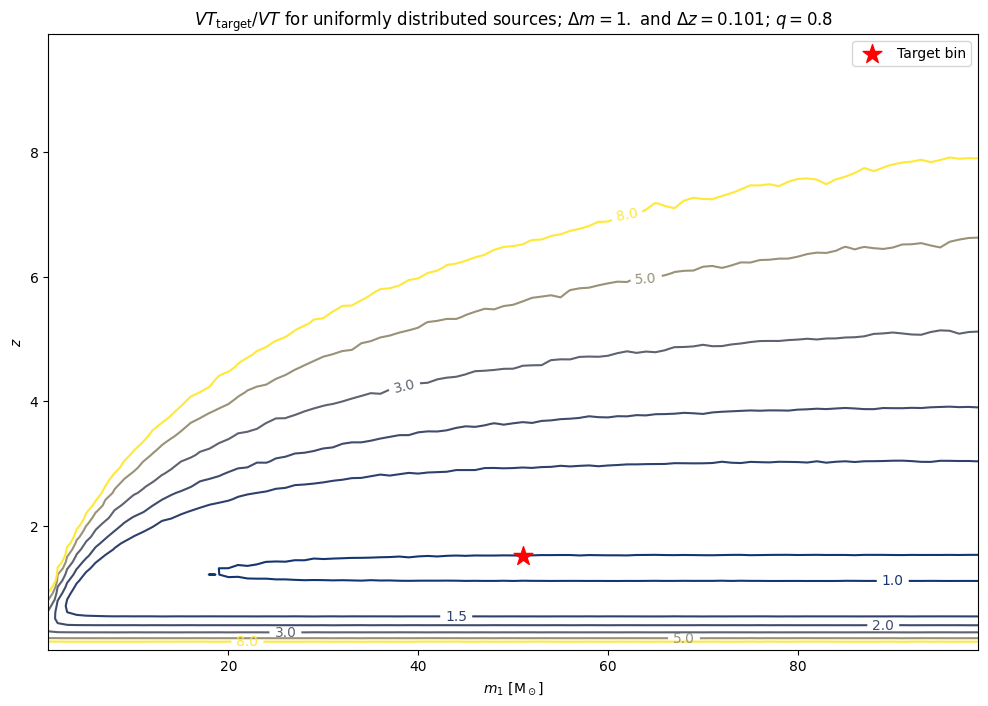

In [14]:
# # Define the target bin using its relative position in the grid
# rx, ry = 0.5, 0.3
# target_bin = (int(rx * (VT.T.shape[0] - 1)), int(ry * (VT.T.shape[1] - 1)))

target_bin = (50, 15)

target_VT = VT.T[*target_bin]
VT_ratio_map = target_VT / VT

fig, ax = plt.subplots(figsize=(12, 8))

ax.set_title(r'${{VT}}_\text{{target}} / VT$ for uniformly distributed sources; $\Delta m = {0}$ and $\Delta z = {1}$; $q = {2}$'.format(np.format_float_positional((m1_max - m1_min) / (m1_len - 1), 3),
                                                                                                                                         np.format_float_positional((z_max - z_min) / (z_len - 1), 3),
                                                                                                                                         np.format_float_positional(q, 3)))
ax.set_xlabel(r'$m_1\ [\text{M}_\odot$]')
ax.set_ylabel(r'$z$')

cmap = plt.colormaps['cividis']
levels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.5, 2, 3, 5, 8]

cf = ax.contour(m1[:-1], z[:-1], VT_ratio_map, levels=levels, cmap=cmap)
ax.clabel(cf)

ax.scatter(m1[target_bin[0]], z[target_bin[1]], color='red', marker='*', s=200, zorder=100, label='Target bin')

ax.legend()

plt.show()